In [1]:
import sys
import os
import pathlib
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
sys.path.insert(1, '../')
from model import Model
import random
from sklearn import metrics
import seaborn as sns
import math

In [2]:
img_size = 28
batch_size = 256
AUTOTUNE = tf.data.AUTOTUNE
class_names = []

def get_data(mode, position=''):
    if mode == 'one_letter':
        train_dirs = [pathlib.Path('../dataset/train/one_letter/normal/prepared'), pathlib.Path('../dataset/train/one_letter/medium/prepared'), pathlib.Path('../dataset/train/one_letter/bold/prepared')]
        test_dirs = [pathlib.Path('../dataset/test/one_letter/normal/prepared'), pathlib.Path('../dataset/test/one_letter/medium/prepared'), pathlib.Path('../dataset/test/one_letter/bold/prepared')]
    elif mode == 'two_letters':
        train_dirs = [pathlib.Path(f'../dataset/train/two_letters_combined/{position}')]
        test_dirs = [pathlib.Path(f'../dataset/test/two_letters_combined/{position}')]
    else:
        train_dirs = [pathlib.Path('../dataset/train/two_letters_combined/first'), pathlib.Path('../dataset/train/one_letter/normal/prepared'), pathlib.Path('../dataset/train/one_letter/medium/prepared'), pathlib.Path('../dataset/train/one_letter/bold/prepared')]
        test_dirs = [pathlib.Path('../dataset/test/two_letters_combined/first'), pathlib.Path('../dataset/test/one_letter/normal/prepared'), pathlib.Path('../dataset/test/one_letter/medium/prepared'), pathlib.Path('../dataset/test/one_letter/bold/prepared')]


    train_ds_list = tf.data.Dataset.list_files(str(train_dirs[0]/'*/*'), shuffle=True).take(1000 if mode != 'one_two' else 3000)
    for train_dir in train_dirs[1:]:
        train_ds_list = train_ds_list.concatenate(tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=True).take(1000))

    image_count = len(train_ds_list)
    train_ds_list = train_ds_list.shuffle(image_count, reshuffle_each_iteration=True)
    train_ds = train_ds_list.take(1000)

    test_ds_list = tf.data.Dataset.list_files(str(test_dirs[0]/'*/*'), shuffle=True).take(1000 if mode != 'one_two' else 3000)
    for test_dir in test_dirs[1:]:
        test_ds_list = test_ds_list.concatenate(tf.data.Dataset.list_files(str(test_dir/'*/*'), shuffle=True).take(1000))

    image_count = len(test_ds_list)
    test_ds_list = test_ds_list.shuffle(image_count, reshuffle_each_iteration=True)
    test_ds = test_ds_list.take(2000)

    return train_ds, test_ds


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    if len(class_names) == 2:
        one_hot = parts[-3] == ['prepared', 'first']
    else:
        one_hot = parts[-2] == class_names
    return one_hot


def decode_img(img):
    # convert the compressed string to a 1D uint8 tensor
    img = tf.image.decode_png(img, channels=1)
    img = img / 255
    # resize the image to the desired size - this doesn't work as cv resize!!!
    # return tf.image.resize(img, [img_size, img_size])
    return img


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def analyze_dataset(ds):
    plt.figure(figsize=(8,6))
    if len(class_names) == 2:
        ds_letters = list(ds.map(lambda file_path: tf.strings.split(file_path, os.path.sep)[-3], num_parallel_calls=AUTOTUNE))
        ds_letters_indexes = list(map(lambda x: int(x.numpy().decode("utf-8") == 'first'), ds_letters))
    else:
        ds_letters = list(ds.map(lambda file_path: tf.strings.split(file_path, os.path.sep)[-2], num_parallel_calls=AUTOTUNE))
        ds_letters_indexes = list(map(lambda x: ord(x.numpy().decode("utf-8")) - 97, ds_letters))
        
    bincounts = np.bincount(ds_letters_indexes)
    #print(bincounts)
    plt.title(f'Velicina skupa: {np.sum(bincounts)}')
    plt.bar(class_names, bincounts)
    plt.show()
    
def show_training_data(ds, class_count, output_dir):
    images = [[] for _ in range(class_count)]
    for images_labels in ds:
        for index in range(len(images_labels[1])):
            label_list = list(map(lambda x: 1 if x else 0, images_labels[1][index].numpy()))
            label = label_list.index(1)
            img = images_labels[0][index].numpy()
            if len(images[label]) < 10:
                images[label].append(img)

    fig, axs = plt.subplots(class_count,10, figsize=(10,class_count))
    fig.tight_layout()

    for i in range(class_count):
        for j in range(10):
            axs[i,j].imshow(images[i][j], cmap=plt.cm.gray)
            axs[i,j].set_axis_off()

    plt.savefig(f'{output_dir}/training_data.pdf', format='pdf', bbox_inches='tight')

    
def show_random_data_with_label(ds, output_dir):
    indexes = random.sample(range(batch_size), 25)
    fig, axs = plt.subplots(5,5, figsize=(12,12))
    fig.tight_layout(pad=5.0)

    for images_labels in ds.take(1):
        for i in range(5):
            for j in range(5):
                index = indexes[i*5+j]
                label_list = list(map(lambda x: 1 if x else 0, images_labels[1][index].numpy()))
                label = class_names[label_list.index(1)]
                img = images_labels[0][index].numpy()
                axs[i,j].imshow(img, cmap=plt.cm.gray)
                axs[i,j].set_axis_off()
                axs[i,j].set_title(f'klasa: {label}\n', fontsize=30 if len(label) == 1 else 22)
                
    plt.savefig(f'{output_dir}/test_data_random_25.pdf', format='pdf', bbox_inches='tight')
    
def get_true_predicted_labels(model, ds, class_names):
    true_labels = []
    predicted_labels = []
    for x, y in ds:
        true_labels.extend(class_names[model.predict(x).argmax(axis=1)])
        predicted_labels.extend(class_names[y.numpy().argmax(axis=1)])
    return true_labels, predicted_labels

def confusion_matrix(true_labels, predicted_labels, class_names):
    plt.figure(figsize=(15,8))
    ax = plt.subplot()
    sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels), annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Prediktovane vrednosti')
    ax.set_ylabel('Stvarne vrednosti')
    ax.set_title('Matrica konfuzije')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names, rotation='horizontal')
    plt.show()
    plt.clf()
    
def get_wrong_predictions(model, ds, class_names):
    result_predicted_labels = []
    result_true_labels = []
    result_wrong_images = []
    for images, labels in ds:
        predicted_labels = class_names[model.predict(images).argmax(axis=1)]
        true_labels = class_names[labels.numpy().argmax(axis=1)]
        wrong_indexes = [i for i in range(len(predicted_labels)) if predicted_labels[i] != true_labels[i]]
        result_wrong_images.extend(images.numpy()[wrong_indexes])
        result_true_labels.extend(true_labels[wrong_indexes])
        result_predicted_labels.extend(predicted_labels[wrong_indexes])
    return result_wrong_images, result_true_labels, result_predicted_labels

def show_wrong_results(ds, wrong_images, wrong_true_labels, wrong_predicted_labels, output_dir):
    image_count = 9 if len(class_names) == 2 else 25
    image_sqrt = int(math.sqrt(image_count))
    indexes = random.sample(range(len(wrong_images)), min(image_count, len(wrong_images)))
    fig, axs = plt.subplots(image_sqrt, image_sqrt, figsize=(12,12))
    fig.tight_layout(pad=5.0)

    for images_labels in ds.take(1):
        for i in range(image_sqrt):
            for j in range(image_sqrt):
                if i*image_sqrt+j >= len(indexes):
                    continue
                index = indexes[i*image_sqrt+j]
                img = wrong_images[index]
                axs[i,j].imshow(img, cmap=plt.cm.gray)
                axs[i,j].set_axis_off()
                axs[i,j].set_title(f'({wrong_true_labels[index]}, {wrong_predicted_labels[index]})\n', fontsize=30)
                
    plt.savefig(f'{output_dir}/wrong_predictions.pdf', format='pdf', bbox_inches='tight')

def demo(class_names_local, mode, position=''):
    global class_names
    class_names = class_names_local
    
    print('Klase', class_names)
    output_dir = mode if position == '' else f'{mode}/{position}'
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    train_ds, test_ds = get_data(mode, position)
        
    print("Prikazivanje trening podataka...")
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    train_ds = configure_for_performance(train_ds)
    show_training_data(train_ds, len(class_names), output_dir)
    
    analyze_dataset(test_ds)
    test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = configure_for_performance(test_ds)
    show_random_data_with_label(test_ds, output_dir)
    
    model = tf.keras.models.load_model(f'../model/{output_dir}/model.h5')
    
    print("Predikcije u toku...")
    test_scores = model.evaluate(test_ds)
    print("Test %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))
    test_labels, test_predicted = get_true_predicted_labels(model, test_ds, class_names)
    print(metrics.accuracy_score(test_labels, test_predicted))
    
    confusion_matrix(test_labels, test_predicted, class_names)
    
    wrong_images, wrong_true_labels, wrong_predicted_labels = get_wrong_predictions(model, test_ds, class_names)
    show_wrong_results(test_ds, wrong_images, wrong_true_labels, wrong_predicted_labels, output_dir)
    

In [3]:
letters = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

Klase ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
Prikazivanje trening podataka...


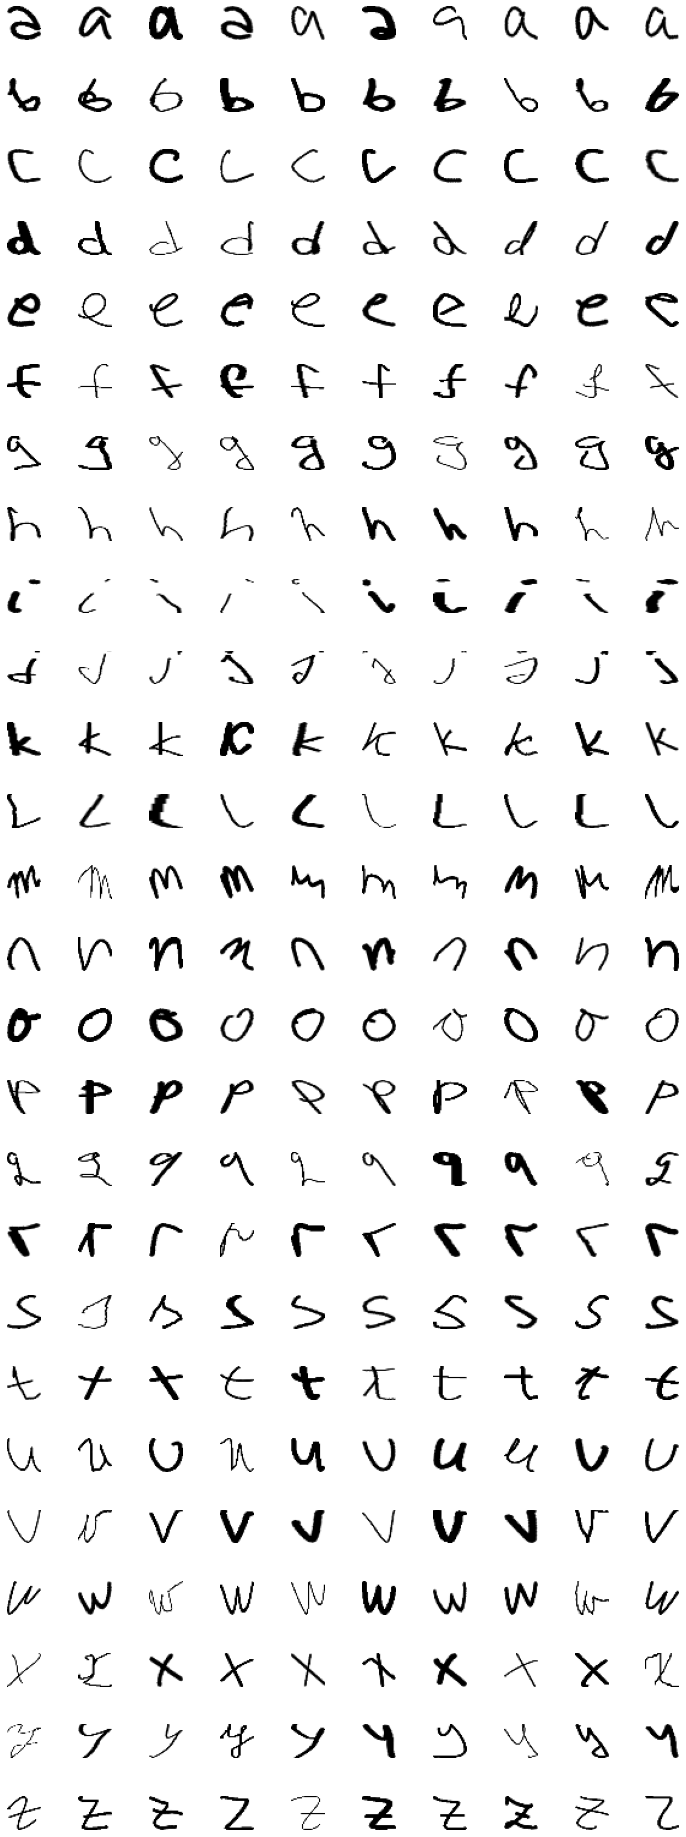

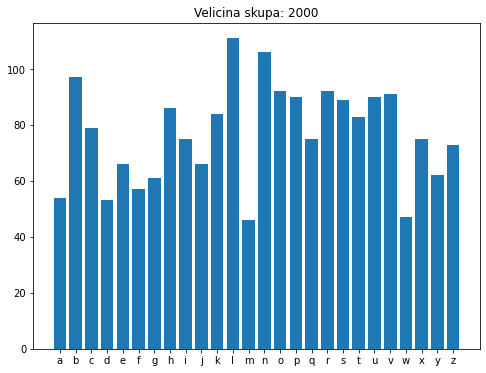

Predikcije u toku...
8/8 [==============================] - 14s 729ms/step - loss: 0.0706 - accuracy: 0.9805
Test accuracy: 98.05%
0.9805


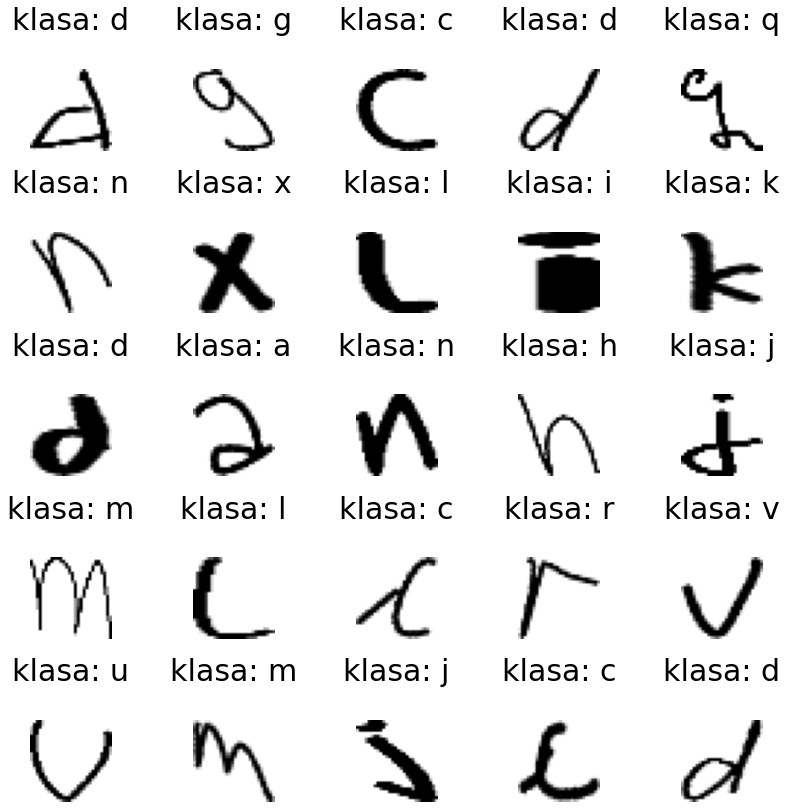

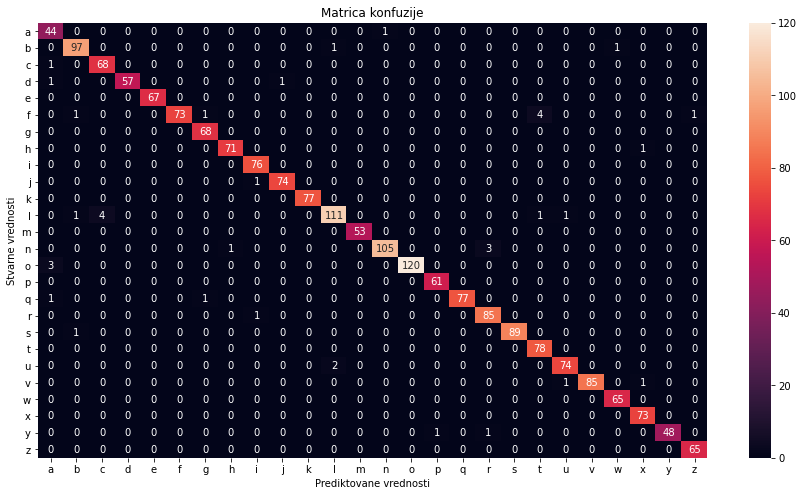

<Figure size 432x288 with 0 Axes>

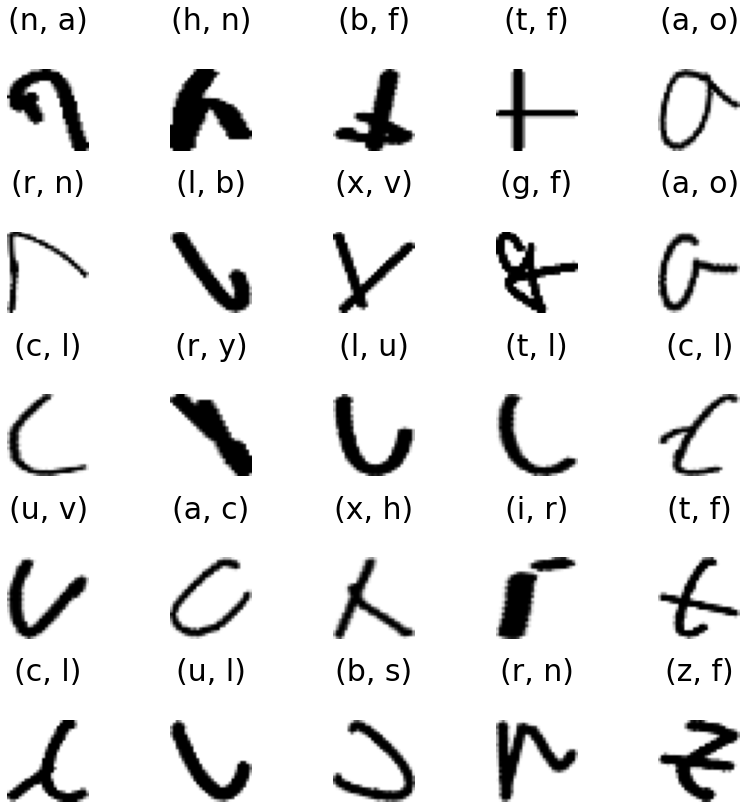

In [6]:
demo(letters, 'one_letter')

Klase ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
Prikazivanje trening podataka...


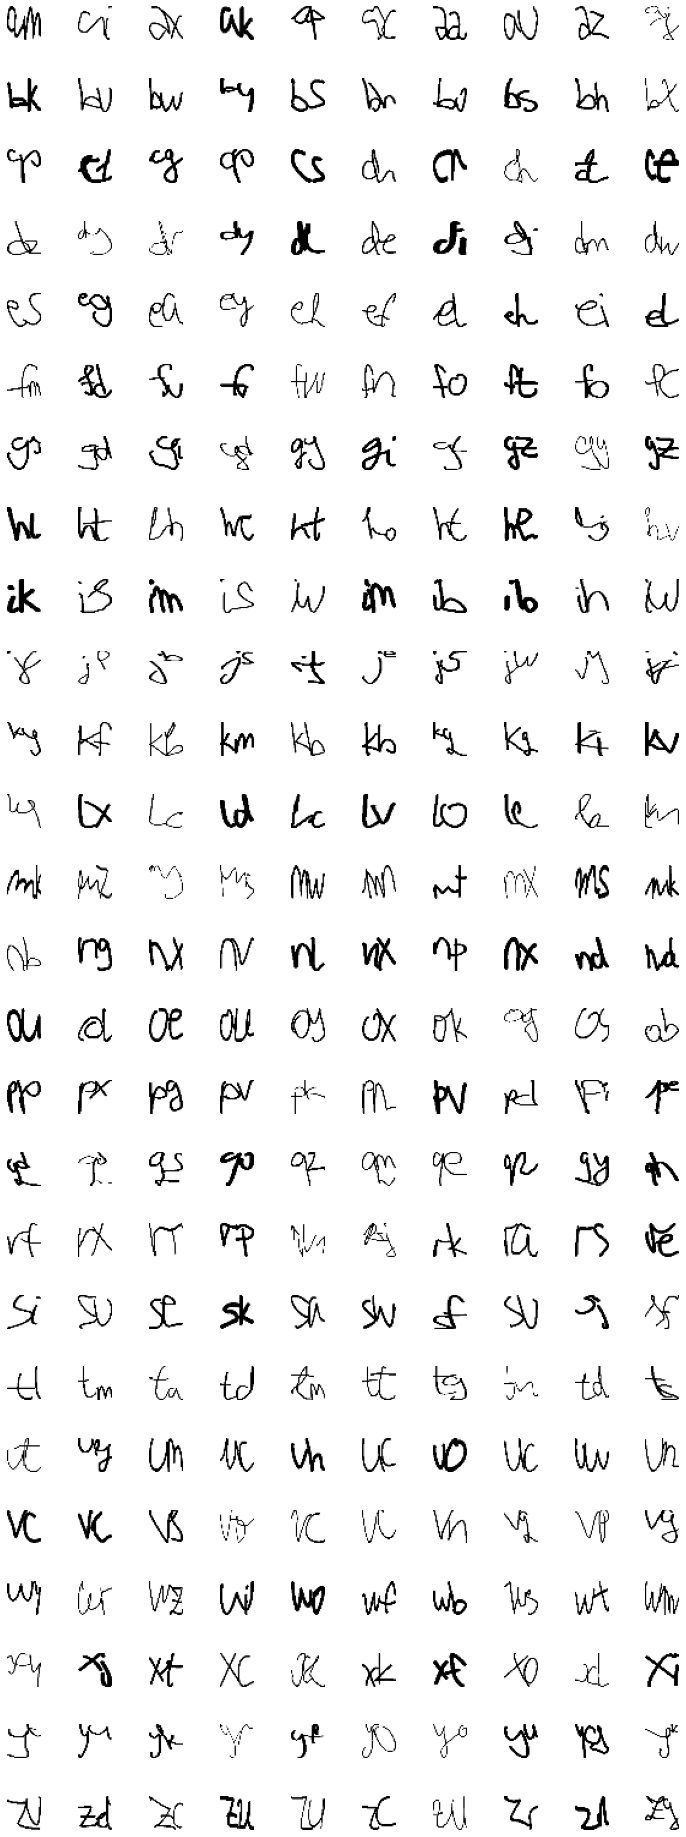

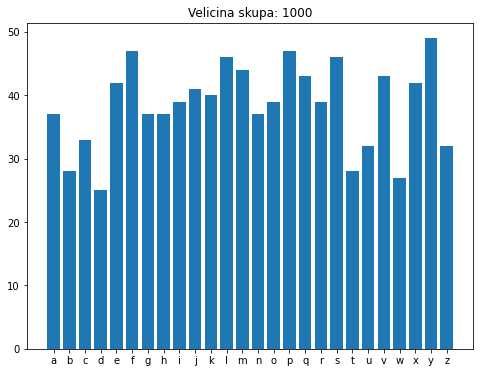

Predikcije u toku...
4/4 [==============================] - 1s 375ms/step - loss: 0.1784 - accuracy: 0.9570
Test accuracy: 95.70%
0.957


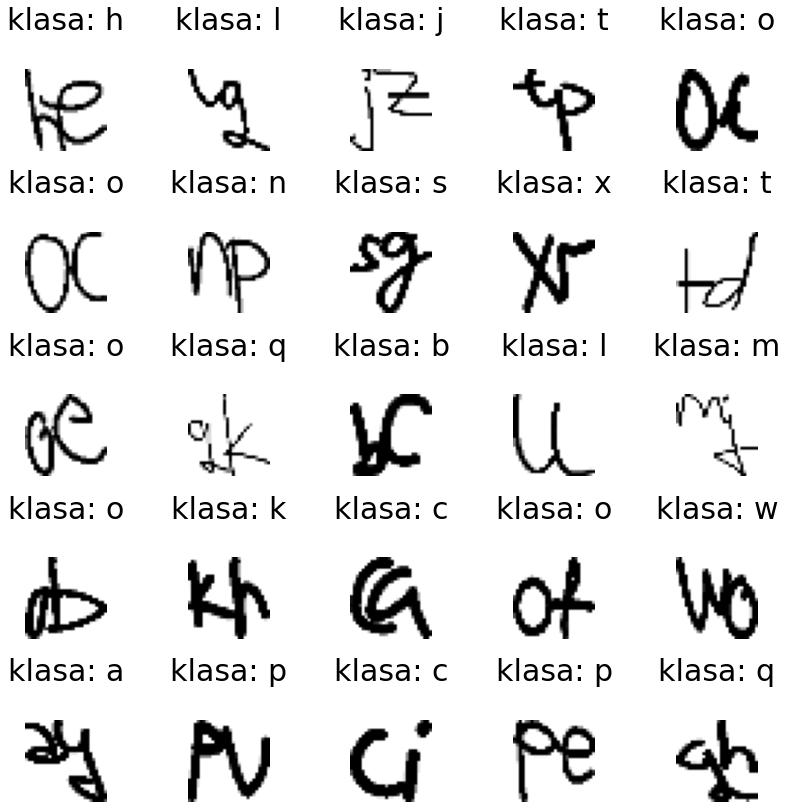

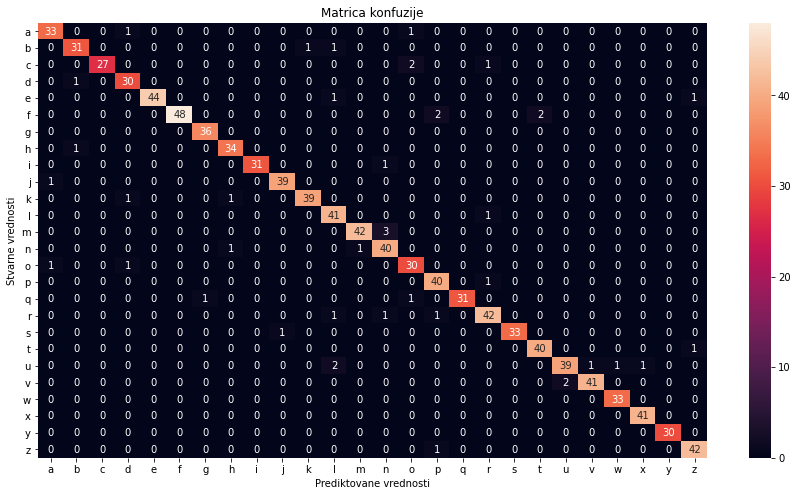

<Figure size 432x288 with 0 Axes>

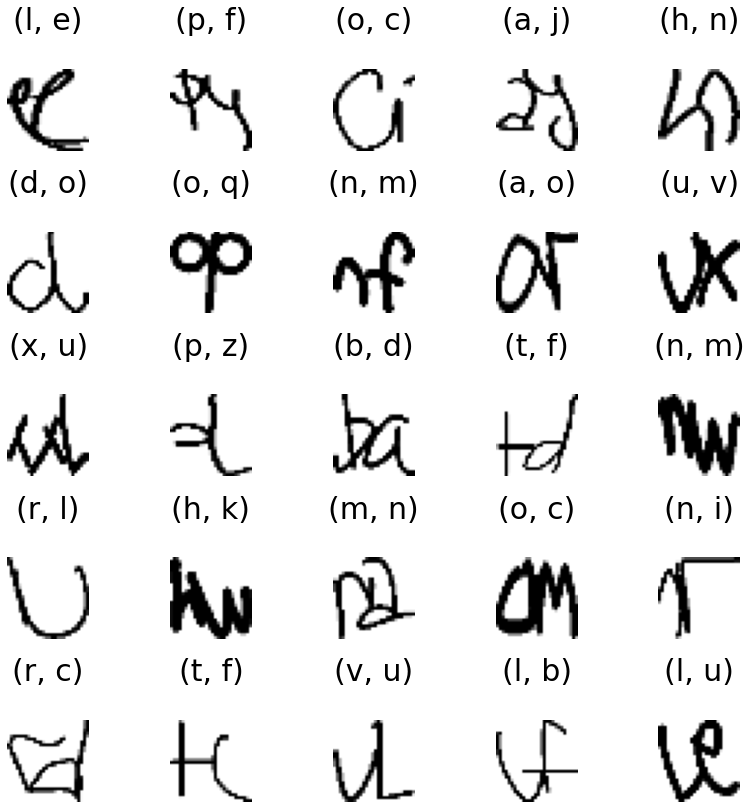

In [5]:
demo(letters, 'two_letters', 'first')

Klase ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
Prikazivanje trening podataka...


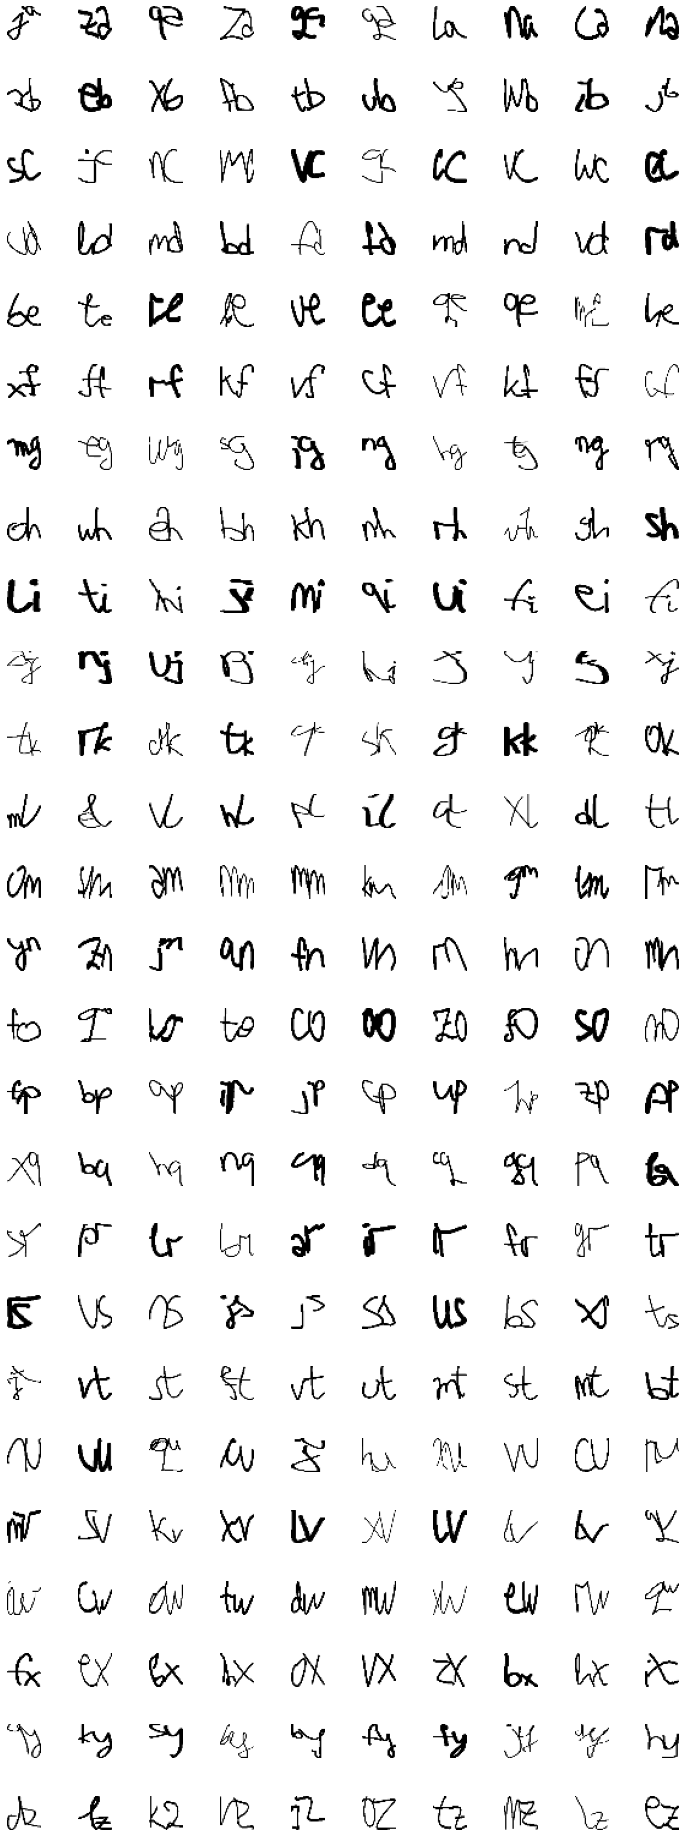

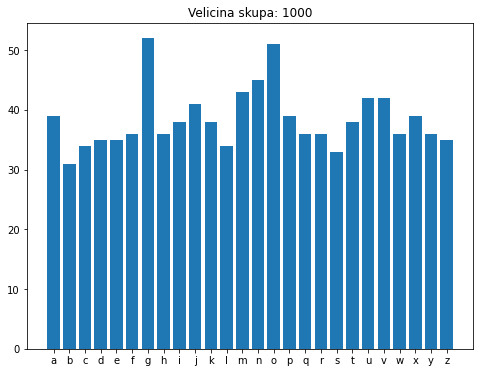

Predikcije u toku...
4/4 [==============================] - 0s 48ms/step - loss: 0.1227 - accuracy: 0.9620
Test accuracy: 96.20%
0.962


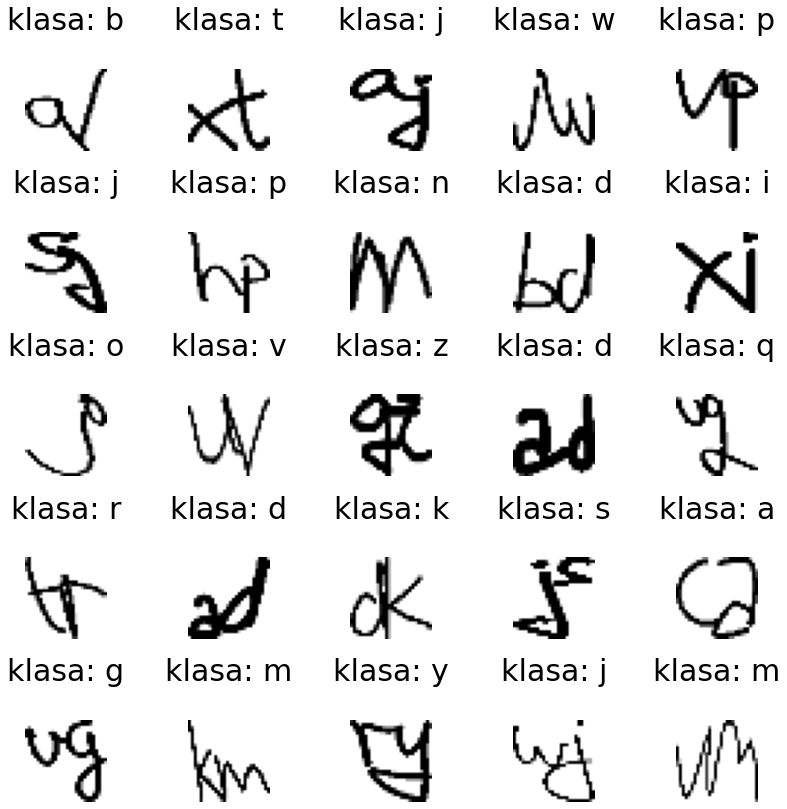

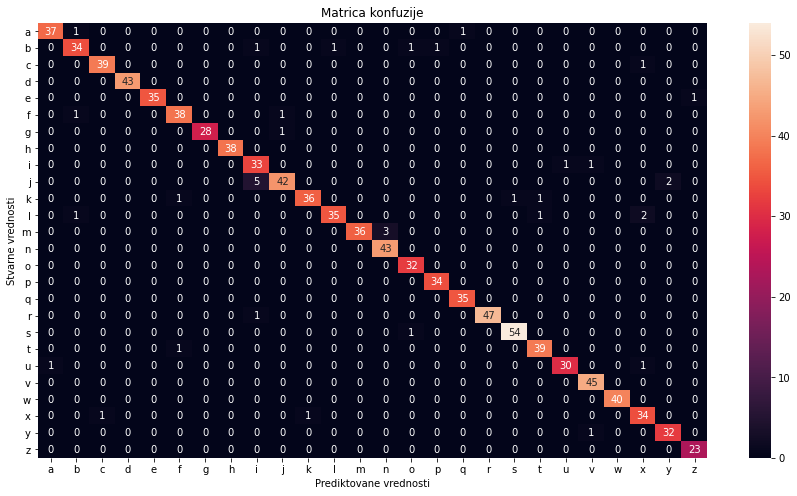

<Figure size 432x288 with 0 Axes>

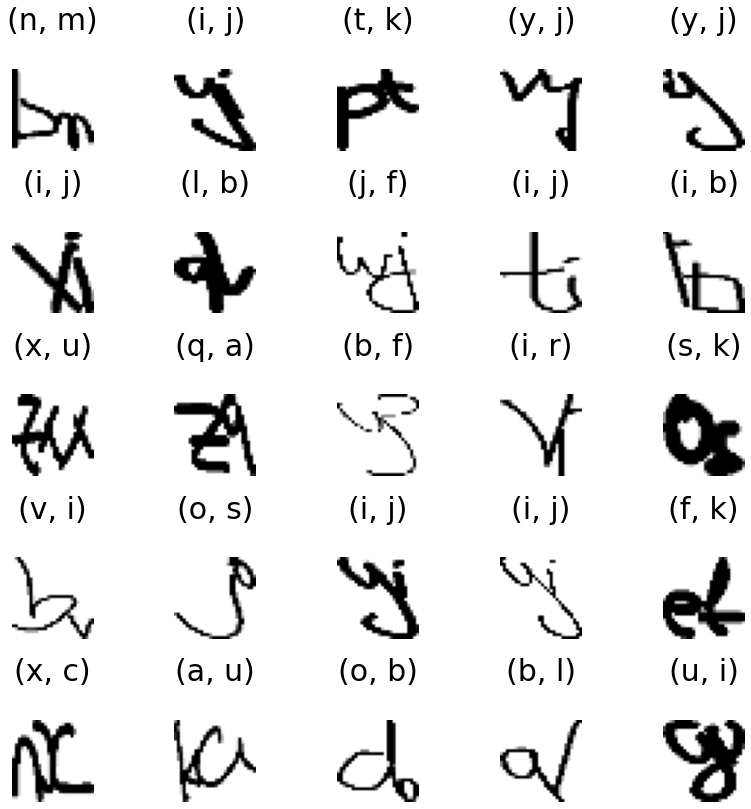

In [6]:
demo(letters, 'two_letters', 'second')

Klase ['slovo' 'bigram']
Prikazivanje trening podataka...


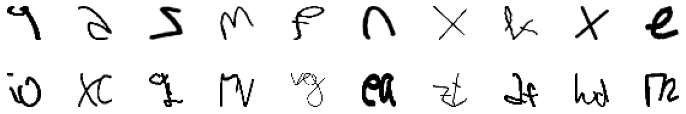

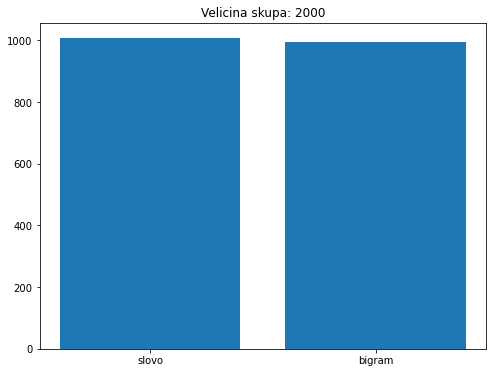

Predikcije u toku...
8/8 [==============================] - 20s 1s/step - loss: 0.0211 - accuracy: 0.9945
Test accuracy: 99.45%
0.9945


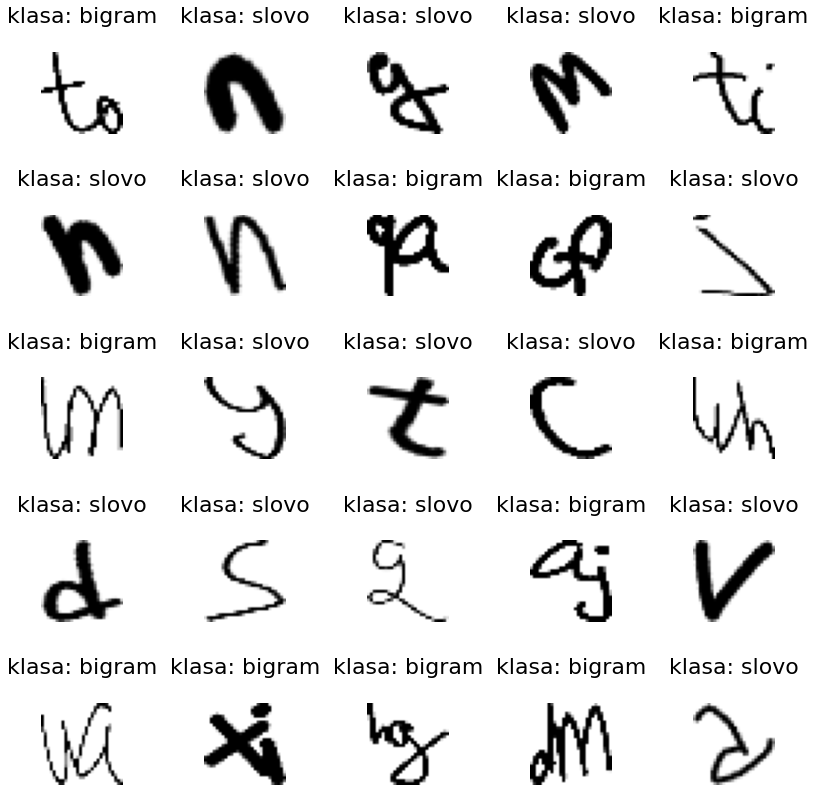

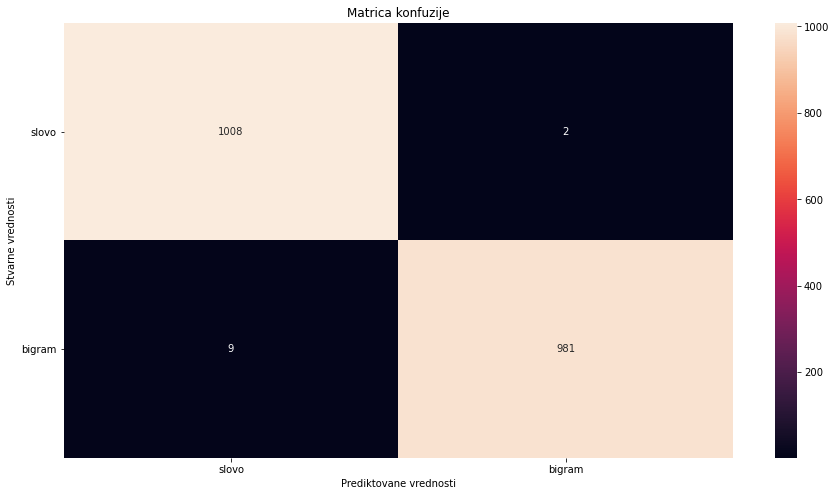

<Figure size 432x288 with 0 Axes>

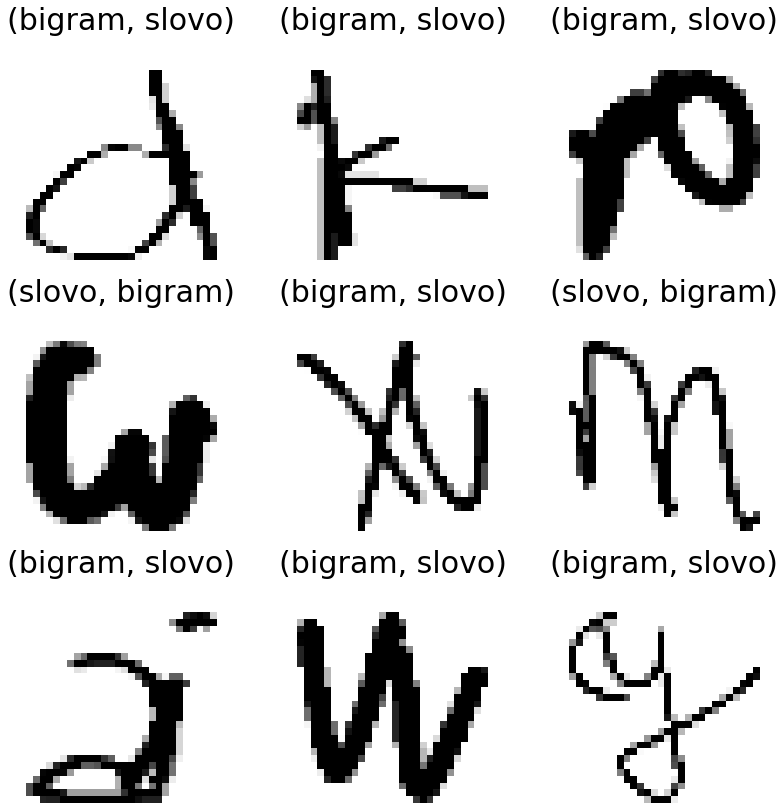

In [7]:
demo(np.array(['slovo', 'bigram']), 'one_two')